In [1]:
import sys

PWD = '../..'
sys.path.append(PWD)

import uproot
import awkward

import numpy as np
from matplotlib import pyplot as plt

from collections import defaultdict
from pprint import pprint

import os
from joblib import Parallel, delayed

from src.plot_utils import plot_sample

In [2]:
files_root_dir = PWD + '/data/base/'

N_JOBS = 8

In [3]:
class FileData:
    def __init__(self, name):
        self.name = name
        self.raw_contents = None
        self.events = None
        
        self.coincidences = None
        self.sorted_channels = None
        
        self.event_lists = None
        self.channel_dict = None

In [4]:
files = [FileData(file_name) for file_name in os.listdir(files_root_dir)]

[file.name for file in files]

['Ntuple_runsampic_159_runtelescope_636.root',
 'Ntuple_runsampic_160_runtelescope_637.root',
 'Ntuple_runsampic_161_runtelescope_638.root',
 'Ntuple_runsampic_163_runtelescope_640.root',
 'Ntuple_runsampic_164_runtelescope_641.root',
 'Ntuple_runsampic_165_runtelescope_642.root',
 'Ntuple_runsampic_166_runtelescope_643.root',
 'Ntuple_runsampic_168_runtelescope_646.root',
 'Ntuple_runsampic_169_runtelescope_648.root',
 'Ntuple_runsampic_171_runtelescope_650.root',
 'Ntuple_runsampic_172_runtelescope_651.root']

In [5]:
for file in files:
    file.raw_contents = uproot.open(files_root_dir + '/' + file.name)
    
files[0].raw_contents.keys()

['desy;21', 'desy;20']

# Contents of the file

In [6]:
for file in files:
    key = file.raw_contents.keys()[0]
    file.events = file.raw_contents[key]
    
files[0].events.show()
print(files[0].events.keys())

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
RunSampic            | int32_t                  | AsDtype('>i4')
RunTelescope         | int32_t                  | AsDtype('>i4')
eventIDTelescope     | int32_t                  | AsDtype('>i4')
nTrackParams         | int32_t                  | AsDtype('>i4')
planeID              | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
trackID              | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
triggerID            | int32_t                  | AsDtype('>i4')
timestamp            | int32_t                  | AsDtype('>i4')
xPos                 | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
yPos                 | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
omega                | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
phi                  | std::vector<double> 

In [7]:
files[6].events['num_samples'].array()[20000]

2

In [8]:
files[6].events['trigger_time'].array()[20000]

48.360668770000004

In [9]:
files[6].events['sample_t0'].array()[20000][0]

48.3606675440625

In [10]:
files[6].events['sample_t0'].array()[20000][1]

48.360667544375005

In [11]:
files[6].events['sample_time'].array()[20000][1][1] # time step

1.5625e-10

In [12]:
files[6].events['sample_time'].array(library='np')[20000][1][:10] + files[6].events['sample_t0'].array(library='np')[20000][1]

array([48.36066754, 48.36066754, 48.36066754, 48.36066754, 48.36066755,
       48.36066755, 48.36066755, 48.36066755, 48.36066755, 48.36066755])

# Find number of coincidences with channel 0

In [13]:
def find_coincidences(events, return_sorted_channels=True):
    coincidences = defaultdict(int)
    for i, (n_samples, channels) in enumerate(zip(events['num_samples'].array(), events['sample_channel'].array())):
        if n_samples > 0 and 0 in channels:
            for channel in channels:
                if channel != 0:
                    coincidences[channel] += 1
                    
    if not return_sorted_channels:
        return coincidences
    else:
        sorted_channels = sorted(coincidences, key=coincidences.get, reverse=True)
        return coincidences, sorted_channels

In [14]:
def handle_file_coincidences(file):
    print(f'Processing {file.name} ...')
    return find_coincidences(file.events)

results = Parallel(n_jobs=N_JOBS)(delayed(handle_file_coincidences)(file) for file in files)

for file, (coincidences, sorted_channels) in zip(files, results):
    file.coincidences, file.sorted_channels = coincidences, sorted_channels

In [15]:
for channel in files[0].sorted_channels:
    print(f'{channel:3}: {files[0].coincidences[channel]:6}')

 14:  20260
 26:  19369
 27:  16265
 13:  15633
 25:  15513
 15:  12839
 24:   2113
 12:   1196
 16:    626
 11:    559
 28:    503
 23:    391
 17:    259
 29:    223
 10:    195
 18:    170
 22:    167
  9:    128
 30:    123
 21:    100
 19:     71
  8:     64
 31:     53
 20:     37


# Fill the channel dict

In [16]:
EVENT_KEYS = set(['eventIDSampic', 'sample_ampl', 'sample_channel', 'sample_t0'])

def flip_y(X):
    return (X - 1) * - 1

def fill_channel_dict(events, channels, event_keys=EVENT_KEYS, log=False):
    channel_dict = {}
    for channel in channels:
        if log:
            print(f'{channel}...')
        channel_dict[channel] = {key: [] for key in event_keys}
        for i_event, (n_samples, channels) in enumerate(zip(events['num_samples'], events['sample_channel'])):
            if n_samples > 0 and 0 in channels and channel in channels:
                idx_0 = list(channels).index(0)
                idx_ch = list(channels).index(channel)
                mask = [idx_0, idx_ch]
                
                for key in event_keys:
                    v = events[key][i_event]
                    v = v[mask] if type(v) is np.ndarray else v
                    if key == 'sample_ampl': # flip ampl
                        v = flip_y(v)
                    elif key == 'sample_t0': # convert to ns
                        v *= 1e9 # ns
                    channel_dict[channel][key].append(v)
                    
    return channel_dict

In [17]:
def handle_file_event_lists(file):
    print(f'Processing {file.name} ...')
    return {k: file.events[k].array(library='np') for k in EVENT_KEYS | set(['num_samples'])}

results = Parallel(n_jobs=N_JOBS)(delayed(handle_file_event_lists)(file) for file in files)

for file, event_lists in zip(files, results):
    file.event_lists = event_lists

In [18]:
def handle_file_channel_dict(file):
    print(f'Processing {file.name} ...')
    return fill_channel_dict(file.event_lists, file.sorted_channels)

results = Parallel(n_jobs=N_JOBS)(delayed(handle_file_channel_dict)(file) for file in files)

for file, channel_dict in zip(files, results):
    file.channel_dict = channel_dict

In [19]:
files[0].channel_dict.keys()

dict_keys([14, 26, 27, 13, 25, 15, 24, 12, 16, 11, 28, 23, 17, 29, 10, 18, 22, 9, 30, 21, 19, 8, 31, 20])

In [20]:
files[0].channel_dict[11].keys()

dict_keys(['sample_ampl', 'sample_t0', 'eventIDSampic', 'sample_channel'])

# Save files

In [21]:
for file in files:
    file_name = os.path.splitext(file.name)[0] + '.npz'
    print(f'Processing {file_name} ...')

    np.savez_compressed(PWD + f'/data/extracted/{file_name}', file.channel_dict)

Processing Ntuple_runsampic_159_runtelescope_636.npz ...
Processing Ntuple_runsampic_160_runtelescope_637.npz ...
Processing Ntuple_runsampic_161_runtelescope_638.npz ...
Processing Ntuple_runsampic_163_runtelescope_640.npz ...
Processing Ntuple_runsampic_164_runtelescope_641.npz ...
Processing Ntuple_runsampic_165_runtelescope_642.npz ...
Processing Ntuple_runsampic_166_runtelescope_643.npz ...
Processing Ntuple_runsampic_168_runtelescope_646.npz ...
Processing Ntuple_runsampic_169_runtelescope_648.npz ...
Processing Ntuple_runsampic_171_runtelescope_650.npz ...
Processing Ntuple_runsampic_172_runtelescope_651.npz ...


# Read a new file

In [13]:
new_events = np.load(PWD + f"/data/extracted/{os.path.splitext(files[6].name)[0] + '.npz'}", allow_pickle=True)['arr_0'].flat[0]

In [14]:
new_events.keys()

dict_keys([11, 23, 16, 24, 29, 28, 17, 22, 12, 10, 18, 30, 9, 15, 27, 21, 19, 31, 8, 20, 13, 14, 25, 26])

# Example samples

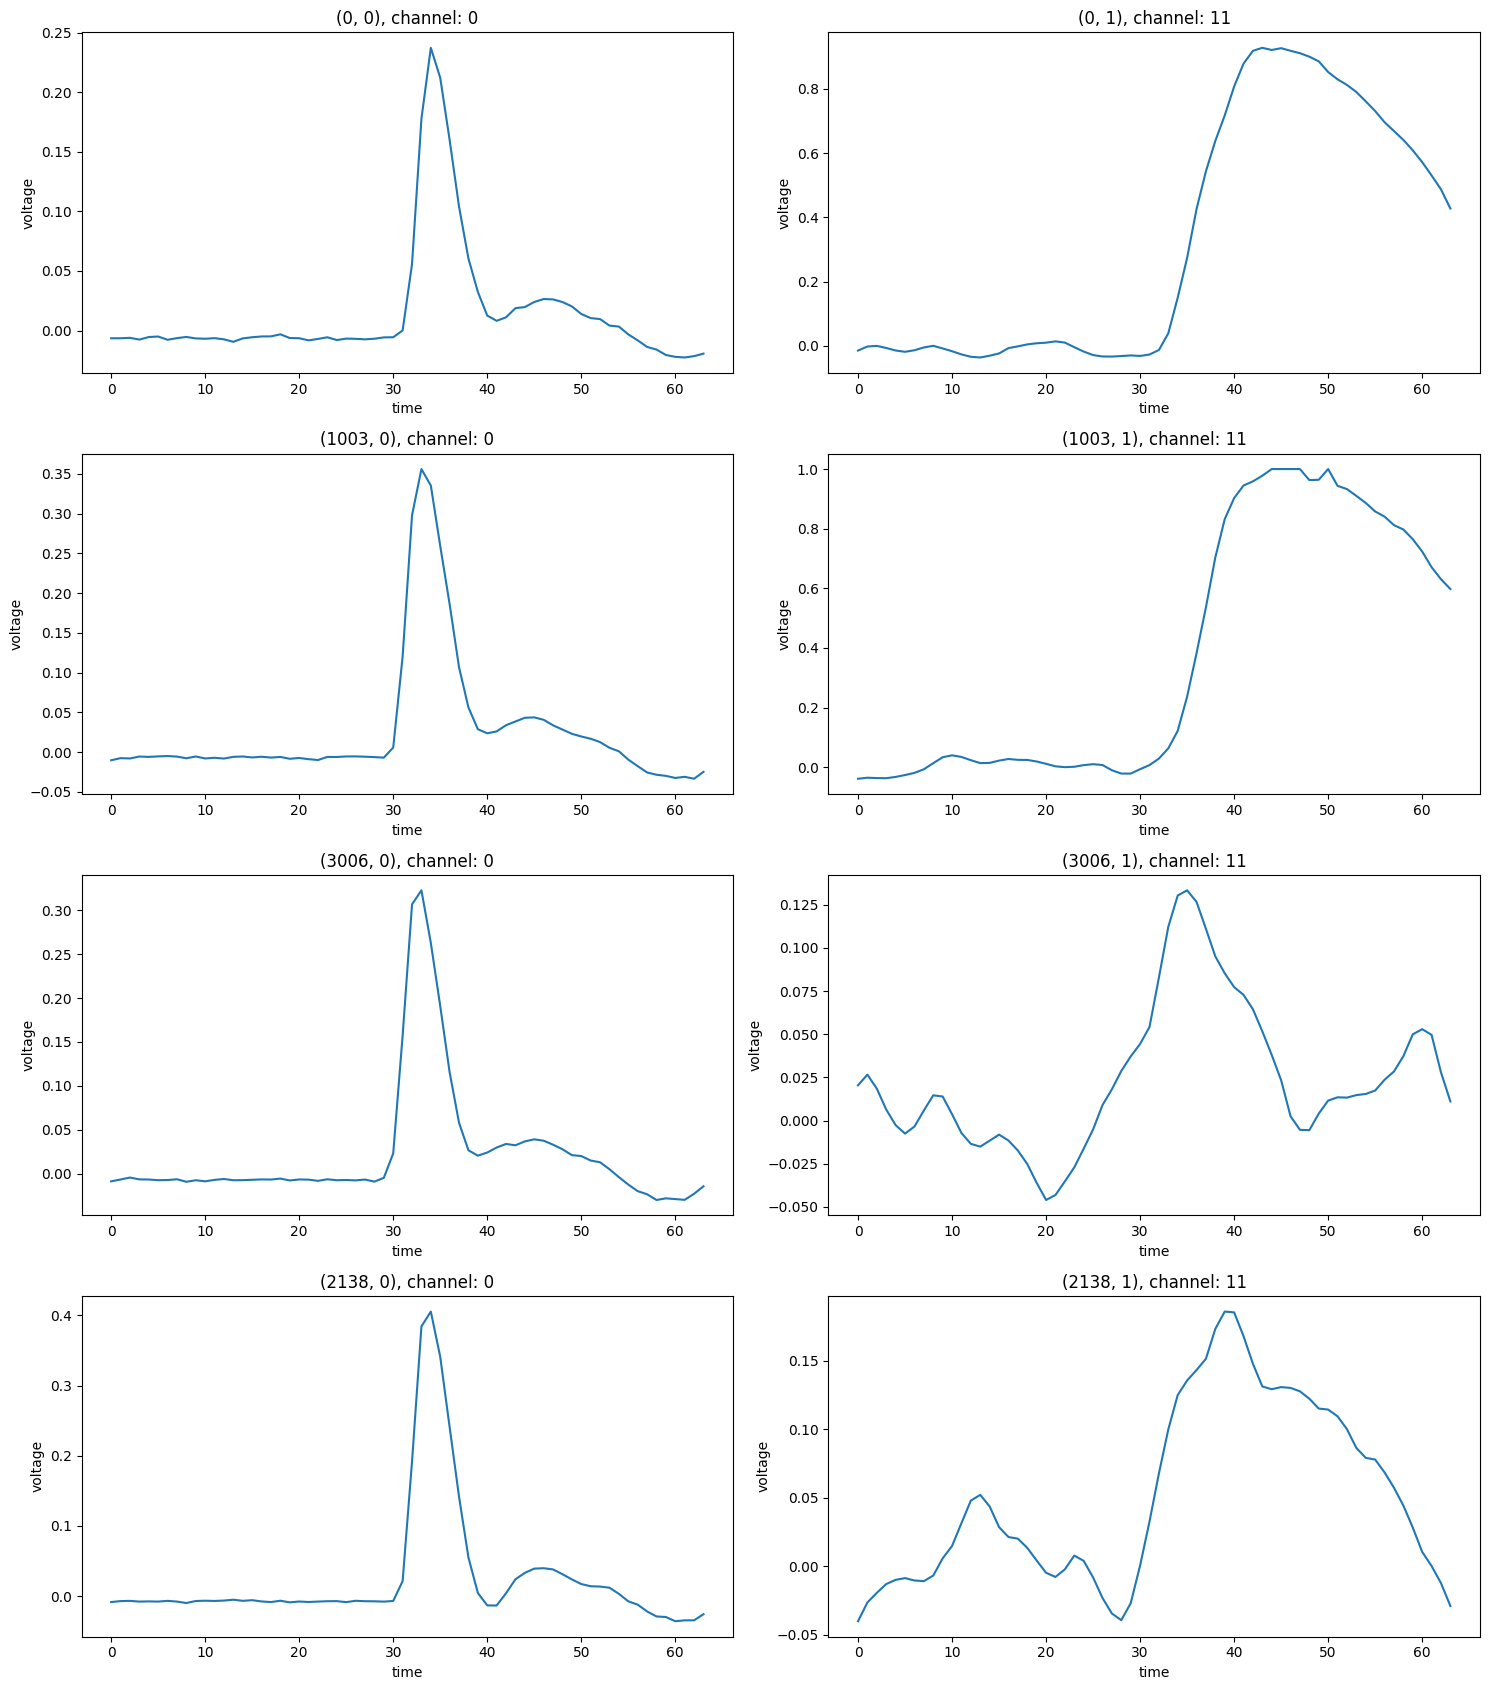

In [15]:
events = [0, 0, 1003, 1003, 3006, 3006, 2138, 2138]
samples = [0, 1, 0, 1, 0, 1, 0, 1]

plt.figure(figsize=(15, 17))
for i, (i_event, i_sample) in enumerate(zip(events, samples)):
    plt.subplot(4, 2, i + 1)
    plot_sample(new_events[11]['sample_ampl'][i_event][i_sample],
                title=f"({i_event}, {i_sample}), channel: {new_events[11]['sample_channel'][i_event][i_sample]}")
    plt.tight_layout()

## Example oversaturated samples

In [16]:
print('Example oversaturated events:')
for i, event in enumerate(new_events[11]['sample_ampl'][:5000]):
    if np.max(event[0]) == 1:
        print(i, end=', ')

Example oversaturated events:
83, 450, 1215, 1724, 1978, 2142, 2150, 2447, 2536, 2745, 2984, 3055, 3484, 3643, 3725, 3916, 4054, 4170, 4283, 4479, 4626, 4644, 

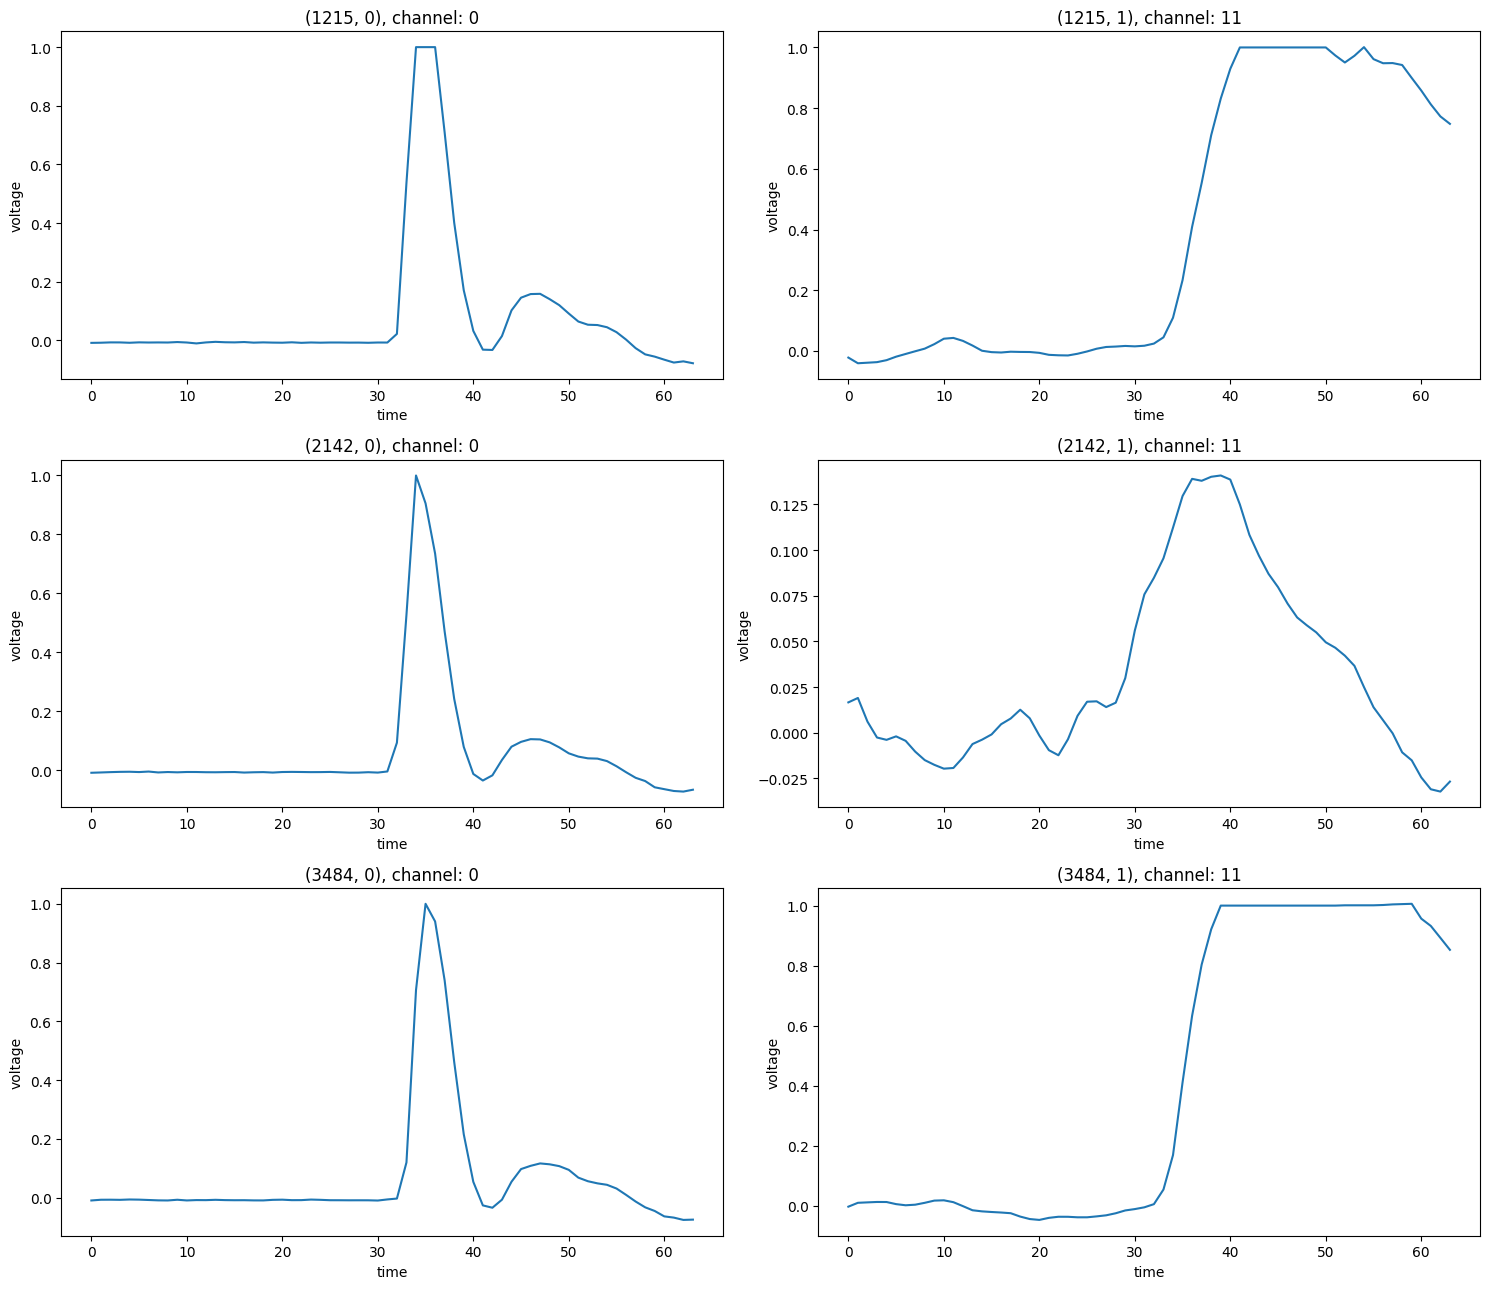

In [17]:
events = [1215, 1215, 2142, 2142, 3484, 3484]
samples = [0, 1, 0, 1, 0, 1]

plt.figure(figsize=(15, 13))
for i, (i_event, i_sample) in enumerate(zip(events, samples)):
    plt.subplot(3, 2, i + 1)
    plot_sample(new_events[11]['sample_ampl'][i_event][i_sample],
                title=f"({i_event}, {i_sample}), channel: {new_events[11]['sample_channel'][i_event][i_sample]}")
    plt.tight_layout()